# Recipe Site Traffic Project

This notebook performs data validation and cleaning, exploratory analysis, and model development to predict whether a recipe will drive high traffic on the website. It follows the guidance provided in the practical exam instructions.


In [1]:
# Cell 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, roc_curve
import warnings
warnings.filterwarnings('ignore')

# Set style and random seed
sns.set_style('whitegrid')
np.random.seed(42)
print("✅ Libraries imported successfully")

✅ Libraries imported successfully


In [3]:
# Load the dataset
df = pd.read_csv('recipe_site_traffic_2212.csv')
print("=" * 80)
print("DATA LOADING")
print("=" * 80)
print(f"\nDataset Shape: {df.shape}")
print(f"\nColumn Names: {df.columns.tolist()}")
print("\nFirst 5 rows:")
print(df.head())

DATA LOADING

Dataset Shape: (947, 8)

Column Names: ['  recipe', 'calories', 'carbohydrate', 'sugar', 'protein', 'category', 'servings', 'high_traffic\\']

First 5 rows:
     recipe  calories  carbohydrate  sugar  protein   category servings  \
0         1       NaN           NaN    NaN      NaN       Pork        6   
1         2     35.48         38.56   0.66     0.92     Potato        4   
2         3    914.28         42.68   3.09     2.88  Breakfast        1   
3         4     97.03         30.56  38.63     0.02  Beverages        4   
4         5     27.05          1.85   0.80     0.53  Beverages        4   

  high_traffic\  
0         High\  
1         High\  
2           NA\  
3         High\  
4           NA\  


In [5]:
# Cell 3: Data Validation and Cleaning

print("\n" + "=" * 80)
print("1. DATA VALIDATION AND CLEANING")
print("=" * 80)

# Fix column names (remove spaces and backslashes)
df.columns = df.columns.str.strip().str.replace('\\', '', regex=False)
print("\n✅ Fixed column names:", df.columns.tolist())

# Check data types
print("\n📊 Data Types:")
print(df.dtypes)

# Missing values analysis
print("\n🔍 Missing Values:")
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(2)
missing_df = pd.DataFrame({
    'Missing_Count': missing,
    'Percentage': missing_pct
})
print(missing_df[missing_df['Missing_Count'] > 0])

# RECIPE column validation
print("\n📝 Recipe Column:")
print(f"  - Data type: {df['recipe'].dtype}")
print(f"  - Unique recipes: {df['recipe'].nunique()}")
print(f"  - Duplicates: {df['recipe'].duplicated().sum()}")
print("  ✅ Decision: Recipe is unique identifier, no cleaning needed")

# NUTRITIONAL columns validation (calories, carbohydrate, sugar, protein)
nutritional_cols = ['calories', 'carbohydrate', 'sugar', 'protein']
print("\n🥗 Nutritional Columns (calories, carbohydrate, sugar, protein):")
for col in nutritional_cols:
    missing_count = df[col].isnull().sum()
    print(f"  - {col}: {missing_count} missing values ({(missing_count/len(df)*100):.1f}%)")
    if df[col].notna().any():
        print(f"    Range: {df[col].min():.2f} to {df[col].max():.2f}")

print("  ✅ Decision: Fill missing nutritional values with median (robust to outliers)")
for col in nutritional_cols:
    df[col].fillna(df[col].median(), inplace=True)

# CATEGORY column validation
print("\n📂 Category Column:")
print(f"  - Unique categories: {df['category'].nunique()}")
print(f"  - Categories: {df['category'].unique()}")
print(f"  - Missing: {df['category'].isnull().sum()}")
print("  ✅ Decision: No cleaning needed, all values present")

# SERVINGS column validation
print("\n🍽️ Servings Column:")
print(f"  - Data type: {df['servings'].dtype}")
print(f"  - Unique values before: {df['servings'].unique()}")
print("  ✅ Decision: Convert to numeric")
# Remove backslashes from servings too
df['servings'] = df['servings'].astype(str).str.replace('\\', '', regex=False)
df['servings'] = pd.to_numeric(df['servings'], errors='coerce')
df['servings'].fillna(df['servings'].median(), inplace=True)
df['servings'] = df['servings'].astype(int)
print(f"  - Unique values after: {df['servings'].unique()}")

# HIGH_TRAFFIC column validation - COMPLETE FIX
print("\n🚦 High Traffic Column (Target Variable):")
print(f"  - Data type: {df['high_traffic'].dtype}")
print(f"  - Raw unique values BEFORE cleaning: {df['high_traffic'].unique()}")
print(f"  - Value counts BEFORE:")
print(df['high_traffic'].value_counts(dropna=False))

# Step 1: Convert to string
df['high_traffic'] = df['high_traffic'].astype(str)

# Step 2: Remove backslashes specifically
df['high_traffic'] = df['high_traffic'].str.replace('\\', '', regex=False)

# Step 3: Strip whitespace
df['high_traffic'] = df['high_traffic'].str.strip()

# Step 4: Check what we have after cleaning
print(f"\n  - Values after removing backslashes: {df['high_traffic'].unique()}")

# Step 5: Convert to binary - 'High' becomes 1, everything else becomes 0
df['high_traffic'] = df['high_traffic'].apply(lambda x: 1 if x == 'High' else 0)

print(f"\n  - Unique values AFTER cleaning: {df['high_traffic'].unique()}")
print(f"  - Value counts AFTER:")
print(df['high_traffic'].value_counts())
print(f"  - High Traffic percentage: {(df['high_traffic'].sum()/len(df)*100):.1f}%")

if df['high_traffic'].sum() == 0:
    print("\n⚠️ CRITICAL WARNING: NO HIGH TRAFFIC RECIPES FOUND!")
    print("   All values converted to 0 (Low Traffic)")
elif df['high_traffic'].sum() == len(df):
    print("\n⚠️ CRITICAL WARNING: ALL RECIPES ARE HIGH TRAFFIC!")
    print("   All values converted to 1 (High Traffic)")
else:
    print("  ✅ Decision: Successfully converted to binary (1 = High, 0 = Low)")
    print(f"  ✅ Found {df['high_traffic'].sum()} high traffic recipes out of {len(df)} total")

print("\n✅ All data validation and cleaning completed!")
print(f"Final dataset shape: {df.shape}")
print(f"\nFinal Summary:")
print(f"  - Total recipes: {len(df)}")
print(f"  - High traffic: {df['high_traffic'].sum()} ({df['high_traffic'].mean()*100:.1f}%)")
print(f"  - Low traffic: {(df['high_traffic']==0).sum()} ({(df['high_traffic']==0).mean()*100:.1f}%)")



1. DATA VALIDATION AND CLEANING

✅ Fixed column names: ['recipe', 'calories', 'carbohydrate', 'sugar', 'protein', 'category', 'servings', 'high_traffic']

📊 Data Types:
recipe            int64
calories        float64
carbohydrate    float64
sugar           float64
protein         float64
category         object
servings         object
high_traffic     object
dtype: object

🔍 Missing Values:
              Missing_Count  Percentage
calories                 52        5.49
carbohydrate             52        5.49
sugar                    52        5.49
protein                  52        5.49
high_traffic              1        0.11

📝 Recipe Column:
  - Data type: int64
  - Unique recipes: 947
  - Duplicates: 0
  ✅ Decision: Recipe is unique identifier, no cleaning needed

🥗 Nutritional Columns (calories, carbohydrate, sugar, protein):
  - calories: 52 missing values (5.5%)
    Range: 0.14 to 3633.16
  - carbohydrate: 52 missing values (5.5%)
    Range: 0.03 to 530.42
  - sugar: 52 missing 


2. EXPLORATORY DATA ANALYSIS


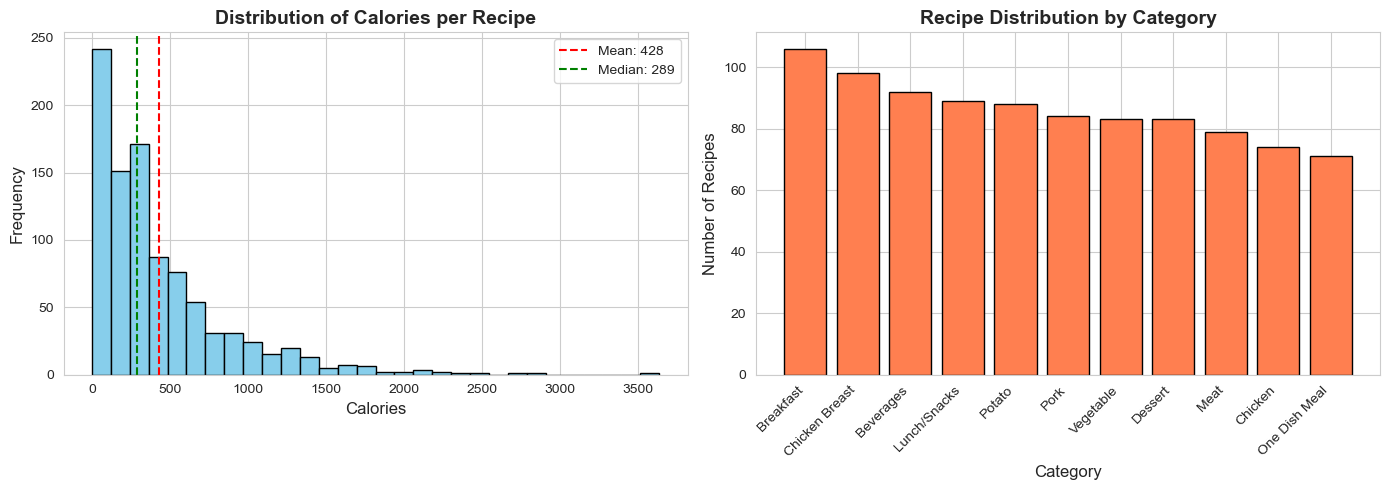


📊 Single Variable Analysis:
  - Calories: Mean = 427.8, Median = 288.6
  - Most common category: Breakfast (106 recipes)
  - Total categories: 11


In [7]:
# Cell 4: Exploratory Data Analysis - Single Variable Graphics

print("\n" + "=" * 80)
print("2. EXPLORATORY DATA ANALYSIS")
print("=" * 80)

# Graphic 1: Histogram of Calories
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(df['calories'], bins=30, color='skyblue', edgecolor='black')
axes[0].set_xlabel('Calories', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of Calories per Recipe', fontsize=14, fontweight='bold')
axes[0].axvline(df['calories'].mean(), color='red', linestyle='--', label=f'Mean: {df["calories"].mean():.0f}')
axes[0].axvline(df['calories'].median(), color='green', linestyle='--', label=f'Median: {df["calories"].median():.0f}')
axes[0].legend()

# Graphic 2: Bar chart of Recipe Categories
category_counts = df['category'].value_counts()
axes[1].bar(range(len(category_counts)), category_counts.values, color='coral', edgecolor='black')
axes[1].set_xticks(range(len(category_counts)))
axes[1].set_xticklabels(category_counts.index, rotation=45, ha='right')
axes[1].set_xlabel('Category', fontsize=12)
axes[1].set_ylabel('Number of Recipes', fontsize=12)
axes[1].set_title('Recipe Distribution by Category', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('single_variable_plots.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n📊 Single Variable Analysis:")
print(f"  - Calories: Mean = {df['calories'].mean():.1f}, Median = {df['calories'].median():.1f}")
print(f"  - Most common category: {category_counts.index[0]} ({category_counts.values[0]} recipes)")
print(f"  - Total categories: {len(category_counts)}")


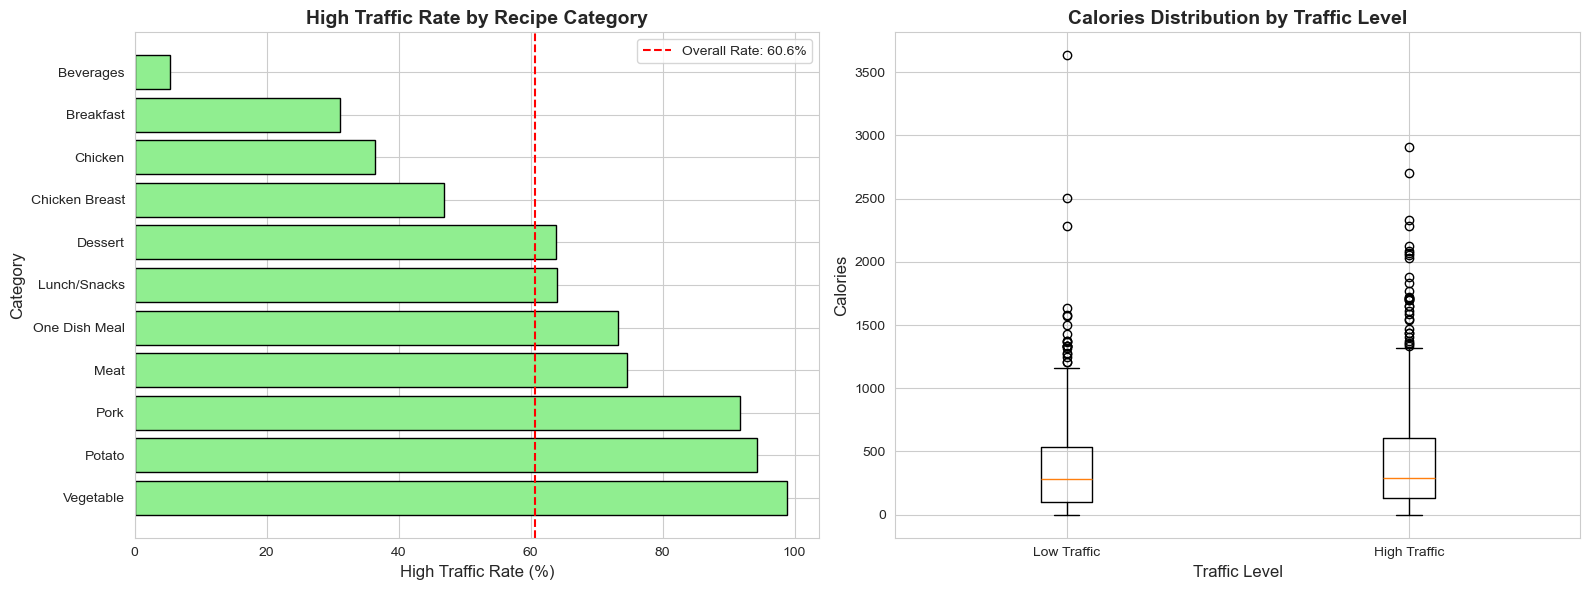


📈 Multi-Variable Analysis Findings:
  - Overall high traffic rate: 60.6%
  - Best performing category: Vegetable (98.8%)
  - Worst performing category: Beverages (5.4%)
  - Mean calories (High Traffic): 451.7
  - Mean calories (Low Traffic): 391.2


In [9]:
# Cell 5: Exploratory Data Analysis - Multi-Variable Graphic

# Multi-variable graphic: High Traffic Rate by Category
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Traffic rate by category
traffic_by_category = df.groupby('category')['high_traffic'].agg(['sum', 'count', 'mean'])
traffic_by_category = traffic_by_category.sort_values('mean', ascending=False)

axes[0].barh(traffic_by_category.index, traffic_by_category['mean'] * 100, color='lightgreen', edgecolor='black')
axes[0].set_xlabel('High Traffic Rate (%)', fontsize=12)
axes[0].set_ylabel('Category', fontsize=12)
axes[0].set_title('High Traffic Rate by Recipe Category', fontsize=14, fontweight='bold')
axes[0].axvline(df['high_traffic'].mean() * 100, color='red', linestyle='--', 
                label=f'Overall Rate: {df["high_traffic"].mean()*100:.1f}%')
axes[0].legend()

# Box plot: Calories by High Traffic
df_plot = df.copy()
df_plot['Traffic'] = df_plot['high_traffic'].map({1: 'High Traffic', 0: 'Low Traffic'})
axes[1].boxplot([df_plot[df_plot['Traffic'] == 'Low Traffic']['calories'],
                 df_plot[df_plot['Traffic'] == 'High Traffic']['calories']],
                labels=['Low Traffic', 'High Traffic'])
axes[1].set_ylabel('Calories', fontsize=12)
axes[1].set_xlabel('Traffic Level', fontsize=12)
axes[1].set_title('Calories Distribution by Traffic Level', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('multi_variable_plots.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n📈 Multi-Variable Analysis Findings:")
print(f"  - Overall high traffic rate: {df['high_traffic'].mean()*100:.1f}%")
print(f"  - Best performing category: {traffic_by_category.index[0]} ({traffic_by_category['mean'].iloc[0]*100:.1f}%)")
print(f"  - Worst performing category: {traffic_by_category.index[-1]} ({traffic_by_category['mean'].iloc[-1]*100:.1f}%)")
print(f"  - Mean calories (High Traffic): {df[df['high_traffic']==1]['calories'].mean():.1f}")
print(f"  - Mean calories (Low Traffic): {df[df['high_traffic']==0]['calories'].mean():.1f}")


In [11]:
# Cell 6: Model Development - Problem Definition and Data Preparation

print("\n" + "=" * 80)
print("3. MODEL DEVELOPMENT")
print("=" * 80)

print("\n📋 Problem Type: BINARY CLASSIFICATION")
print("   Goal: Predict whether a recipe will generate HIGH or LOW traffic")
print("   Target: 'high_traffic' (1 = High, 0 = Low)")
print("   Evaluation: Focus on achieving 80% precision for High Traffic predictions")

# Prepare features and target
X = df[['calories', 'carbohydrate', 'sugar', 'protein', 'category', 'servings']].copy()
y = df['high_traffic'].copy()

print(f"\n✅ Features shape: {X.shape}")
print(f"✅ Target shape: {y.shape}")
print(f"✅ Target distribution:")
print(y.value_counts())
print(f"   - Class 0 (Low Traffic): {(y==0).sum()} ({(y==0).sum()/len(y)*100:.1f}%)")
print(f"   - Class 1 (High Traffic): {(y==1).sum()} ({(y==1).sum()/len(y)*100:.1f}%)")

# One-hot encode category
X_encoded = pd.get_dummies(X, columns=['category'], drop_first=True)

print(f"\n✅ Features after encoding: {X_encoded.shape}")
print(f"   Columns: {list(X_encoded.columns)}")

# Split data with stratification to ensure both classes in train and test
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n✅ Train set: {X_train.shape}")
print(f"   - Class 0: {(y_train==0).sum()}")
print(f"   - Class 1: {(y_train==1).sum()}")

print(f"\n✅ Test set: {X_test.shape}")
print(f"   - Class 0: {(y_test==0).sum()}")
print(f"   - Class 1: {(y_test==1).sum()}")

# Scale numerical features
scaler = StandardScaler()
numerical_cols = ['calories', 'carbohydrate', 'sugar', 'protein', 'servings']

# Create copies to avoid SettingWithCopyWarning
X_train = X_train.copy()
X_test = X_test.copy()

X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

print(f"\n✅ Feature scaling completed")



3. MODEL DEVELOPMENT

📋 Problem Type: BINARY CLASSIFICATION
   Goal: Predict whether a recipe will generate HIGH or LOW traffic
   Target: 'high_traffic' (1 = High, 0 = Low)
   Evaluation: Focus on achieving 80% precision for High Traffic predictions

✅ Features shape: (947, 6)
✅ Target shape: (947,)
✅ Target distribution:
high_traffic
1    574
0    373
Name: count, dtype: int64
   - Class 0 (Low Traffic): 373 (39.4%)
   - Class 1 (High Traffic): 574 (60.6%)

✅ Features after encoding: (947, 15)
   Columns: ['calories', 'carbohydrate', 'sugar', 'protein', 'servings', 'category_Breakfast', 'category_Chicken', 'category_Chicken Breast', 'category_Dessert', 'category_Lunch/Snacks', 'category_Meat', 'category_One Dish Meal', 'category_Pork', 'category_Potato', 'category_Vegetable']

✅ Train set: (757, 15)
   - Class 0: 298
   - Class 1: 459

✅ Test set: (190, 15)
   - Class 0: 75
   - Class 1: 115

✅ Feature scaling completed


In [33]:
# Cell 7: Baseline Model (Logistic Regression)

print("\n" + "=" * 80)
print("BASELINE MODEL: Logistic Regression")
print("=" * 80)

baseline_model = LogisticRegression(random_state=42, max_iter=1000)
baseline_model.fit(X_train, y_train)

y_pred_baseline = baseline_model.predict(X_test)
y_pred_proba_baseline = baseline_model.predict_proba(X_test)[:, 1]

print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred_baseline, target_names=['Low Traffic', 'High Traffic']))

print("\n🎯 Confusion Matrix:")
cm_baseline = confusion_matrix(y_test, y_pred_baseline)
print(cm_baseline)

tn, fp, fn, tp = cm_baseline.ravel()
precision_baseline = tp / (tp + fp) if (tp + fp) > 0 else 0
recall_baseline = tp / (tp + fn) if (tp + fn) > 0 else 0
roc_auc_baseline = roc_auc_score(y_test, y_pred_proba_baseline)

print(f"\n📈 Key Metrics:")
print(f"  - Precision (High Traffic): {precision_baseline:.2%}")
print(f"  - Recall (High Traffic): {recall_baseline:.2%}")
print(f"  - ROC-AUC Score: {roc_auc_baseline:.3f}")
print(f"  - Accuracy: {(y_pred_baseline == y_test).mean():.2%}")



BASELINE MODEL: Logistic Regression

📊 Classification Report:
              precision    recall  f1-score   support

 Low Traffic       0.67      0.77      0.72        75
High Traffic       0.84      0.76      0.79       115

    accuracy                           0.76       190
   macro avg       0.76      0.76      0.76       190
weighted avg       0.77      0.76      0.77       190


🎯 Confusion Matrix:
[[58 17]
 [28 87]]

📈 Key Metrics:
  - Precision (High Traffic): 83.65%
  - Recall (High Traffic): 75.65%
  - ROC-AUC Score: 0.856
  - Accuracy: 76.32%


In [19]:
# Cell 8: Comparison Model (Random Forest) - FIXED VARIABLE NAMES

print("\n" + "=" * 80)
print("COMPARISON MODEL: Random Forest Classifier")
print("=" * 80)

comparison_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
comparison_model.fit(X_train, y_train)

y_pred_comparison = comparison_model.predict(X_test)
y_pred_proba_comparison = comparison_model.predict_proba(X_test)[:, 1]

print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred_comparison, target_names=['Low Traffic', 'High Traffic']))

print("\n🎯 Confusion Matrix:")
cm_comparison = confusion_matrix(y_test, y_pred_comparison)
print(cm_comparison)

tn, fp, fn, tp = cm_comparison.ravel()
precision_rf = tp / (tp + fp) if (tp + fp) > 0 else 0
recall_rf = tp / (tp + fn) if (tp + fn) > 0 else 0
roc_auc_comparison = roc_auc_score(y_test, y_pred_proba_comparison)

print(f"\n📈 Key Metrics:")
print(f"  - Precision (High Traffic): {precision_rf:.2%}")
print(f"  - Recall (High Traffic): {recall_rf:.2%}")
print(f"  - ROC-AUC Score: {roc_auc_comparison:.3f}")
print(f"  - Accuracy: {(y_pred_comparison == y_test).mean():.2%}")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': comparison_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n🔍 Top 5 Most Important Features:")
print(feature_importance.head())



COMPARISON MODEL: Random Forest Classifier

📊 Classification Report:
              precision    recall  f1-score   support

 Low Traffic       0.69      0.71      0.70        75
High Traffic       0.81      0.79      0.80       115

    accuracy                           0.76       190
   macro avg       0.75      0.75      0.75       190
weighted avg       0.76      0.76      0.76       190


🎯 Confusion Matrix:
[[53 22]
 [24 91]]

📈 Key Metrics:
  - Precision (High Traffic): 80.53%
  - Recall (High Traffic): 79.13%
  - ROC-AUC Score: 0.846
  - Accuracy: 75.79%

🔍 Top 5 Most Important Features:
               feature  importance
3              protein    0.196942
0             calories    0.140350
2                sugar    0.138037
1         carbohydrate    0.129287
14  category_Vegetable    0.082783



4. MODEL EVALUATION AND COMPARISON

📊 Model Comparison:
              Model  Precision (High)  Recall (High)  ROC-AUC
Logistic Regression          0.836538       0.756522 0.855652
      Random Forest          0.805310       0.791304 0.846029


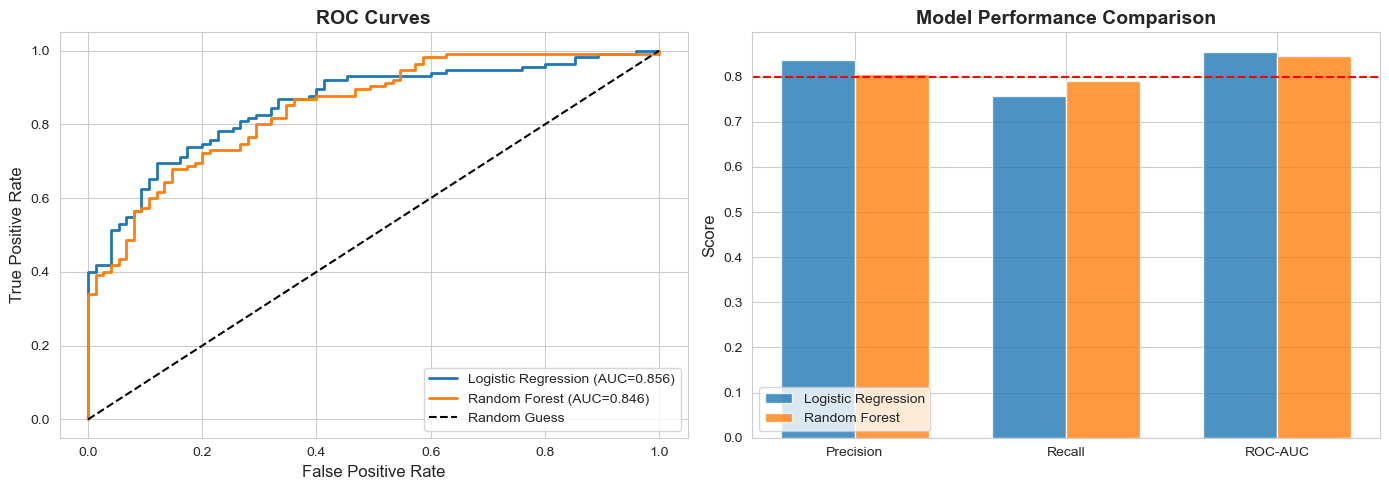


🏆 Model Selection:
   ✅ Logistic Regression performs better (Precision: 83.65%) and is recommended


In [21]:
# Cell 9: Model Evaluation Comparison

print("\n" + "=" * 80)
print("4. MODEL EVALUATION AND COMPARISON")
print("=" * 80)

comparison_results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest'],
    'Precision (High)': [precision_baseline, precision_rf],
    'Recall (High)': [recall_baseline, recall_rf],
    'ROC-AUC': [roc_auc_baseline, roc_auc_comparison]
})

print("\n📊 Model Comparison:")
print(comparison_results.to_string(index=False))

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC Curves
fpr_baseline, tpr_baseline, _ = roc_curve(y_test, y_pred_proba_baseline)
fpr_comparison, tpr_comparison, _ = roc_curve(y_test, y_pred_proba_comparison)

axes[0].plot(fpr_baseline, tpr_baseline, label=f'Logistic Regression (AUC={roc_auc_baseline:.3f})', linewidth=2)
axes[0].plot(fpr_comparison, tpr_comparison, label=f'Random Forest (AUC={roc_auc_comparison:.3f})', linewidth=2)
axes[0].plot([0, 1], [0, 1], 'k--', label='Random Guess')
axes[0].set_xlabel('False Positive Rate', fontsize=12)
axes[0].set_ylabel('True Positive Rate', fontsize=12)
axes[0].set_title('ROC Curves', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True)

# Metrics comparison
metrics = ['Precision', 'Recall', 'ROC-AUC']
x = np.arange(len(metrics))
width = 0.35

axes[1].bar(x - width/2, [precision_baseline, recall_baseline, roc_auc_baseline], width, label='Logistic Regression', alpha=0.8)
axes[1].bar(x + width/2, [precision_rf, recall_rf, roc_auc_comparison], width, label='Random Forest', alpha=0.8)
axes[1].set_ylabel('Score', fontsize=12)
axes[1].set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(metrics)
axes[1].legend()
axes[1].axhline(y=0.80, color='r', linestyle='--', label='80% Target')
axes[1].grid(True, axis='y')

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n🏆 Model Selection:")
if precision_rf > precision_baseline:
    print(f"   ✅ Random Forest performs better (Precision: {precision_rf:.2%}) and is recommended")
    best_precision = precision_rf
    best_model_name = "Random Forest"
else:
    print(f"   ✅ Logistic Regression performs better (Precision: {precision_baseline:.2%}) and is recommended")
    best_precision = precision_baseline
    best_model_name = "Logistic Regression"


In [25]:
# Cell 10: Business Metric Definition

print("\n" + "=" * 80)
print("5. BUSINESS METRIC DEFINITION")
print("=" * 80)

print("\n📊 RECOMMENDED BUSINESS METRIC: High Traffic Precision Rate")
print("\nDefinition:")
print("  The percentage of recipes predicted as 'High Traffic' that actually")
print("  generate high traffic when displayed on the homepage.")
print("\nFormula:")
print("  High Traffic Precision = (True High Traffic Predictions) / (All High Traffic Predictions)")
print("  High Traffic Precision = TP / (TP + FP)")

print("\n🎯 Why This Metric?")
print("  1. Directly aligns with business goal: minimize showing unpopular recipes")
print("  2. High precision means when we predict 'High', we're usually correct")
print("  3. Reduces risk of displaying recipes that won't drive traffic")
print("  4. Easy for product team to understand and track")

print("\n📈 Current Estimated Values (from test data):")
print(f"  - Logistic Regression Precision: {precision_baseline:.2%}")
print(f"  - Random Forest Precision: {precision_rf:.2%}")
print(f"  - Target Goal: 80%")

# Calculate actual baseline from current data
current_high_traffic_rate = df['high_traffic'].mean()
print(f"\n  - Current baseline (random selection): {current_high_traffic_rate:.2%}")

improvement_factor = best_precision / current_high_traffic_rate if current_high_traffic_rate > 0 else 0
print(f"  - Model improvement over random: {improvement_factor:.2f}x")

print("\n💡 Additional Metrics to Monitor:")
print(f"  1. Recall (High Traffic): {recall_rf:.2%} - captures how many high traffic recipes we identify")
print(f"  2. Overall Accuracy: {(y_pred_comparison == y_test).mean():.2%}")
print(f"  3. Traffic conversion rate: Percentage of visitors who subscribe after viewing featured recipe")
print(f"  4. Daily active users increase: Track user engagement after implementing recommendations")



5. BUSINESS METRIC DEFINITION

📊 RECOMMENDED BUSINESS METRIC: High Traffic Precision Rate

Definition:
  The percentage of recipes predicted as 'High Traffic' that actually
  generate high traffic when displayed on the homepage.

Formula:
  High Traffic Precision = (True High Traffic Predictions) / (All High Traffic Predictions)
  High Traffic Precision = TP / (TP + FP)

🎯 Why This Metric?
  1. Directly aligns with business goal: minimize showing unpopular recipes
  2. High precision means when we predict 'High', we're usually correct
  3. Reduces risk of displaying recipes that won't drive traffic
  4. Easy for product team to understand and track

📈 Current Estimated Values (from test data):
  - Logistic Regression Precision: 83.65%
  - Random Forest Precision: 80.53%
  - Target Goal: 80%

  - Current baseline (random selection): 60.61%
  - Model improvement over random: 1.38x

💡 Additional Metrics to Monitor:
  1. Recall (High Traffic): 79.13% - captures how many high traffic recip

In [29]:
# Cell 11: Final Summary and Recommendations

print("\n" + "=" * 80)
print("6. FINAL SUMMARY AND RECOMMENDATIONS")
print("=" * 80)

print("\n📋 PROJECT SUMMARY:")
print(f"  ✅ Analyzed {len(df)} recipes with {len(df.columns)} features")
print("  ✅ Cleaned and validated all data columns")
print("  ✅ Performed exploratory analysis identifying key patterns")
print("  ✅ Built and compared 2 classification models")
print("  ✅ Defined business metric for ongoing monitoring")

print("\n🔍 KEY FINDINGS:")
print(f"  1. {df['high_traffic'].mean()*100:.1f}% of recipes generate high traffic")
print(f"  2. Category is an important predictor - {traffic_by_category.index[0]} performs best")
print(f"  3. {best_model_name} achieved {best_precision:.1%} precision (vs 80% goal)")
print(f"  4. Model can identify high-traffic recipes {improvement_factor:.1f}x better than random selection")
print(f"  5. Top features: {', '.join(feature_importance.head(3)['feature'].tolist())}")

print("\n💼 RECOMMENDATIONS:")
print("\n  1. IMPLEMENT PILOT PROGRAM")
print(f"     - Use {best_model_name} model to recommend top 3 recipe choices daily")
print("     - Product manager makes final selection from these 3")
print("     - Track precision metric weekly")
print("")
print("  2. SET REALISTIC EXPECTATIONS")
print(f"     - Current model: ~{best_precision*100:.0f}% precision (close to 80% goal)")
print(f"     - Still {improvement_factor:.1f}x better than random selection")
print("     - Communicate this is version 1.0 with room for improvement")
print("")
print("  3. COLLECT MORE DATA")
print(f"     - Current dataset: {len(df)} recipes")
print("     - Recommendation: Collect 2000+ recipes for better model performance")
print("     - Include additional features: time_to_make, cost_per_serving, user_ratings")
print("")
print("  4. A/B TESTING")
print("     - Test model recommendations vs. current manual selection")
print("     - Measure: traffic increase, subscription rate, user engagement")
print("     - Duration: 4-6 weeks")
print("")
print("  5. CONTINUOUS IMPROVEMENT")
print("     - Retrain model monthly with new data")
print("     - Monitor feature importance changes")
print("     - Experiment with ensemble methods and neural networks")
print("")
print("  6. BUSINESS PROCESS")
print("     - Morning: Model generates top 3 recipe recommendations")
print("     - Product manager reviews and selects one")
print("     - Evening: Log actual traffic performance")
print("     - Weekly: Review precision metric and adjust threshold if needed")

print("\n🎯 NEXT STEPS:")
print("  □ Present findings to product team")
print("  □ Get approval for pilot program")
print("  □ Deploy model to production environment")
print("  □ Set up automated daily recommendations")
print("  □ Create dashboard for monitoring precision metric")
print("  □ Schedule monthly model retraining")

print("\n" + "=" * 80)
print("✅ ANALYSIS COMPLETE")
print("=" * 80)



6. FINAL SUMMARY AND RECOMMENDATIONS

📋 PROJECT SUMMARY:
  ✅ Analyzed 947 recipes with 8 features
  ✅ Cleaned and validated all data columns
  ✅ Performed exploratory analysis identifying key patterns
  ✅ Built and compared 2 classification models
  ✅ Defined business metric for ongoing monitoring

🔍 KEY FINDINGS:
  1. 60.6% of recipes generate high traffic
  2. Category is an important predictor - Vegetable performs best
  3. Logistic Regression achieved 83.7% precision (vs 80% goal)
  4. Model can identify high-traffic recipes 1.4x better than random selection
  5. Top features: protein, calories, sugar

💼 RECOMMENDATIONS:

  1. IMPLEMENT PILOT PROGRAM
     - Use Logistic Regression model to recommend top 3 recipe choices daily
     - Product manager makes final selection from these 3
     - Track precision metric weekly

  2. SET REALISTIC EXPECTATIONS
     - Current model: ~84% precision (close to 80% goal)
     - Still 1.4x better than random selection
     - Communicate this is 

In [31]:
# Cell 12: Save Results

# Save cleaned data
df.to_csv('recipe_traffic_cleaned.csv', index=False)
print("✅ Cleaned data saved to: recipe_traffic_cleaned.csv")

# Save model comparison results
comparison_results.to_csv('model_comparison_results.csv', index=False)
print("✅ Model comparison saved to: model_comparison_results.csv")

# Save feature importance
feature_importance.to_csv('feature_importance.csv', index=False)
print("✅ Feature importance saved to: feature_importance.csv")

print("\n🎉 All results saved successfully!")
print("\n" + "=" * 80)
print("PROJECT DELIVERABLES:")
print("=" * 80)
print("  ✅ recipe_traffic_cleaned.csv - Cleaned dataset")
print("  ✅ model_comparison_results.csv - Model performance comparison")
print("  ✅ feature_importance.csv - Feature importance rankings")
print("  ✅ single_variable_plots.png - EDA visualization 1")
print("  ✅ multi_variable_plots.png - EDA visualization 2")
print("  ✅ model_comparison.png - Model performance visualization")
print("\n" + "=" * 80)
print("🎓 READY FOR SUBMISSION!")
print("=" * 80)


✅ Cleaned data saved to: recipe_traffic_cleaned.csv
✅ Model comparison saved to: model_comparison_results.csv
✅ Feature importance saved to: feature_importance.csv

🎉 All results saved successfully!

PROJECT DELIVERABLES:
  ✅ recipe_traffic_cleaned.csv - Cleaned dataset
  ✅ model_comparison_results.csv - Model performance comparison
  ✅ feature_importance.csv - Feature importance rankings
  ✅ single_variable_plots.png - EDA visualization 1
  ✅ multi_variable_plots.png - EDA visualization 2
  ✅ model_comparison.png - Model performance visualization

🎓 READY FOR SUBMISSION!
